In [102]:
from pre_processing import load_and_clean_data
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [89]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_clean_data(
    "diabetes_prediction_dataset.csv", split=True
)

In [90]:
# Data Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [91]:
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [79]:
#model = LogisticRegression(class_weight='balanced', max_iter=1000)
#model.fit(X_train_scaled, y_train)

In [80]:
# Validation evaluation
#y_val_pred = model.predict(X_val_scaled)
#print("Validation Set:")
#print(classification_report(y_val, y_val_pred))

In [82]:
# Test evaluation
#y_test_pred = model.predict(X_test_scaled)
# Classification report
#print(classification_report(y_test, y_pred))

In [83]:
# Confusion Matrix
#cm = confusion_matrix(y_test, y_test_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
#disp.plot(cmap='Blues')
#plt.title("Confusion Matrix")
#plt.show()

In [92]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],         # Regularization strength (smaller = stronger regularization)
    'penalty': ['l1', 'l2'],                     # Type of regularization
    'solver': ['liblinear', 'saga'],             # Needed for l1 support
    'class_weight': ['balanced'],                # Keep this to handle imbalance
    'max_iter': [500, 1000]
}
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [93]:
f1_minority = make_scorer(f1_score, pos_label=1)
grid = GridSearchCV(LogisticRegression(), param_grid, scoring=f1_minority, cv=cv, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

Best params: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Best F1 score: 0.5846082867692076


In [94]:
best_model = LogisticRegression(
    C=0.001,
    class_weight='balanced',
    max_iter=500,
    penalty='l2',
    solver='saga'
)

best_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.001, class_weight='balanced', max_iter=500,
                   solver='saga')

In [95]:
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]  # Probabilities for class 1 (diabetes)

In [96]:
custom_threshold = 0.3  # Try 0.2, 0.3, 0.4, etc.
y_val_pred_custom = (y_val_proba >= custom_threshold).astype(int)

In [98]:
# Threshold tuning
for t in [0.3, 0.4, 0.5, 0.6]:
    y_pred_thresh = (y_val_proba >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(classification_report(y_val, y_pred_thresh))


Threshold: 0.3
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      8767
           1       0.30      0.97      0.46       848

    accuracy                           0.80      9615
   macro avg       0.65      0.87      0.67      9615
weighted avg       0.93      0.80      0.84      9615


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      8767
           1       0.37      0.94      0.53       848

    accuracy                           0.85      9615
   macro avg       0.68      0.89      0.72      9615
weighted avg       0.94      0.85      0.88      9615


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      8767
           1       0.44      0.89      0.59       848

    accuracy                           0.89      9615
   macro avg       0.72      0.89      0.76      9615
weighted avg       0.94   

In [99]:
# Final threshold 
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]
custom_threshold = 0.6
y_val_pred_custom = (y_val_proba >= custom_threshold).astype(int)
print(f"\nClassification Report (Threshold = {custom_threshold}):")
print(classification_report(y_val, y_val_pred_custom))


Classification Report (Threshold = 0.6):
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      8767
           1       0.53      0.83      0.65       848

    accuracy                           0.92      9615
   macro avg       0.76      0.88      0.80      9615
weighted avg       0.94      0.92      0.93      9615



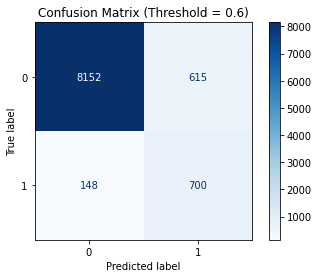

In [100]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_custom)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')  # You can change the colormap
plt.title(f"Confusion Matrix (Threshold = {custom_threshold})")
plt.grid(False)
plt.show()